# Tree / Orchard Inference using Pre-trained Model

This notebook demonstrates how to load the pre-trained `best_model.pth` checkpoint and run inference on a GeoTIFF satellite image to **detect and count trees/orchards** using density-map regression.

## 1. Install Dependencies (if needed)

In [1]:
# Uncomment and run if packages are not already installed
# !pip install torch rasterio numpy matplotlib scipy

## 2. Imports

Import model and utility functions directly from `code/src/`.

In [2]:
import sys, os, glob
import torch
import numpy as np
import matplotlib.pyplot as plt

# Add code/src to path so we can import our modules
sys.path.insert(0, os.path.join(os.getcwd(), 'code', 'src'))

from model import UNet
from utils import read_tif, tensor_to_rgb

print('Imports loaded ✓')

Imports loaded ✓


## 3. Helper Functions

In [3]:
def crop_to_multiple(img, multiple=4):
    """Crop (C, H, W) image so H and W are divisible by `multiple`."""
    c, h, w = img.shape
    return img[:, :h - h % multiple, :w - w % multiple]

def make_overlay(rgb, density):
    """Blend density heatmap onto RGB image."""
    threshold = 0.1 * density.max()
    mask = density > threshold
    overlay = rgb.copy()
    if np.any(mask):
        norm = np.clip((density - threshold) / (density.max() - threshold + 1e-6), 0, 1)
        overlay[mask, 0] = overlay[mask, 0] * 0.3 + (0.8 + 0.2 * norm[mask])
        overlay[mask, 1] *= 0.3
        overlay[mask, 2] *= 0.3
    return np.clip(overlay, 0, 1)

## 4. Load Pre-trained Model

Load the `best_model.pth` checkpoint (trained with density-map regression, lowest validation MAE).

In [4]:
MODEL_PATH = 'best_model.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = UNet(in_channels=3).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

print(f'Model loaded from {MODEL_PATH} ✓')

Using device: cuda
Model loaded from best_model.pth ✓


C:\Users\lmfph\AppData\Local\Temp\ipykernel_19140\2396865041.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=de

## 5. Load a GeoTIFF Image

Point this to any 4-band satellite GeoTIFF. The first 3 bands (B, G, R) will be used.

Image shape: (3, 1940, 2884)
Value range: [0.000, 1.000]


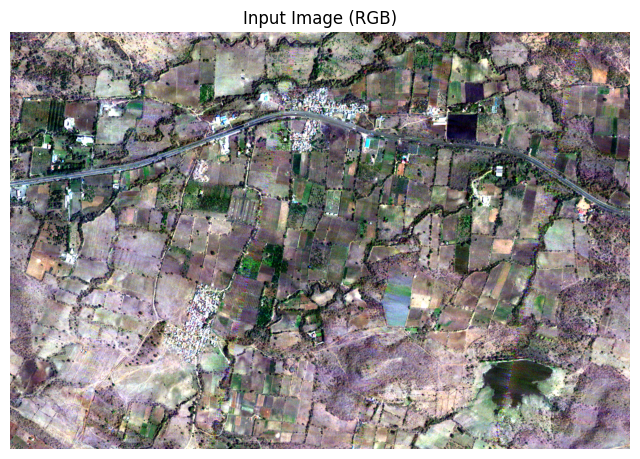

In [5]:
IMAGE_PATH = 'tree_orchard_count_new1.tif'  # <-- change this to your image

img = read_tif(IMAGE_PATH)
img = crop_to_multiple(img, 4)

print(f'Image shape: {img.shape}')
print(f'Value range: [{img.min():.3f}, {img.max():.3f}]')

# Quick preview
rgb = tensor_to_rgb(img)
plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title('Input Image (RGB)')
plt.axis('off')
plt.show()

## 6. Run Inference

Pass the image through the model to get the predicted density map.  
The **sum of the density map** gives the estimated tree count.

In [6]:
inp = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)

with torch.no_grad():
    pred = model(inp)[0, 0].cpu().numpy()

predicted_count = pred.sum()
print(f'Predicted tree count: {predicted_count:.0f}')

Predicted tree count: 95626


## 7. Visualise Results

Three panels:
1. **Original RGB** — the satellite image
2. **Predicted Density Map** — heatmap where the pixel sum ≈ tree count
3. **Overlay** — density heatmap blended onto the original image

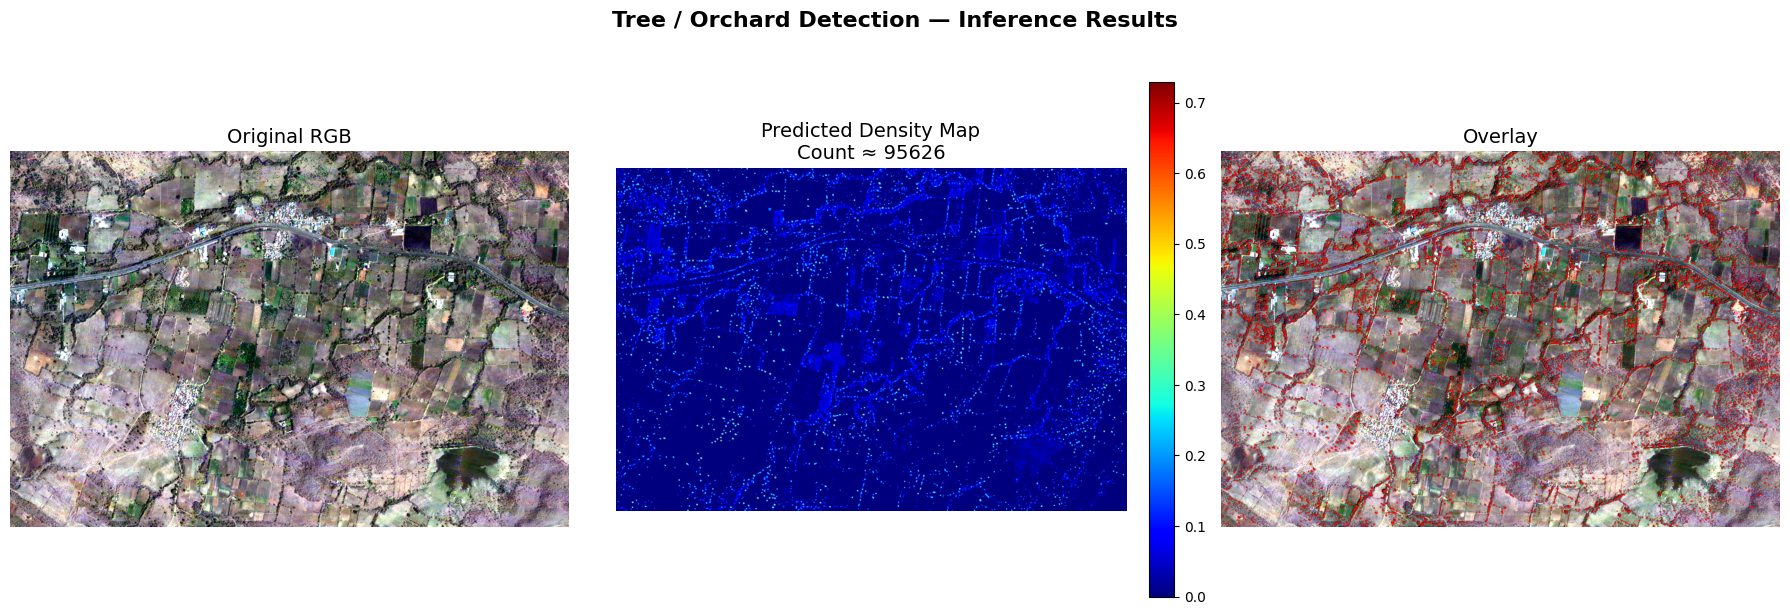

In [7]:
overlay = make_overlay(rgb, pred)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(rgb)
axes[0].set_title('Original RGB', fontsize=14)
axes[0].axis('off')

im = axes[1].imshow(pred, cmap='jet')
axes[1].set_title(f'Predicted Density Map\nCount ≈ {predicted_count:.0f}', fontsize=14)
axes[1].axis('off')
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

axes[2].imshow(overlay)
axes[2].set_title('Overlay', fontsize=14)
axes[2].axis('off')

plt.suptitle('Tree / Orchard Detection — Inference Results', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 8. Inference on Individual Tiles (Optional)

If you have pre-tiled images (512×512 patches), you can run inference on each tile and aggregate counts.

In [8]:
TILE_DIR = 'dataset/image/test'  # <-- change to your tiles directory

tile_paths = sorted(glob.glob(os.path.join(TILE_DIR, '*.tif')))
print(f'Found {len(tile_paths)} tiles')

total_count = 0
tile_counts = []

for path in tile_paths:
    tile = read_tif(path)
    tile = crop_to_multiple(tile, 4)
    inp  = torch.tensor(tile, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        density = model(inp)[0, 0].cpu().numpy()
    count = density.sum()
    tile_counts.append((os.path.basename(path), count))
    total_count += count

Found 40 tiles


## 9. Visualise Top-N Tiles by Count

Plot the tiles with the highest predicted tree counts.

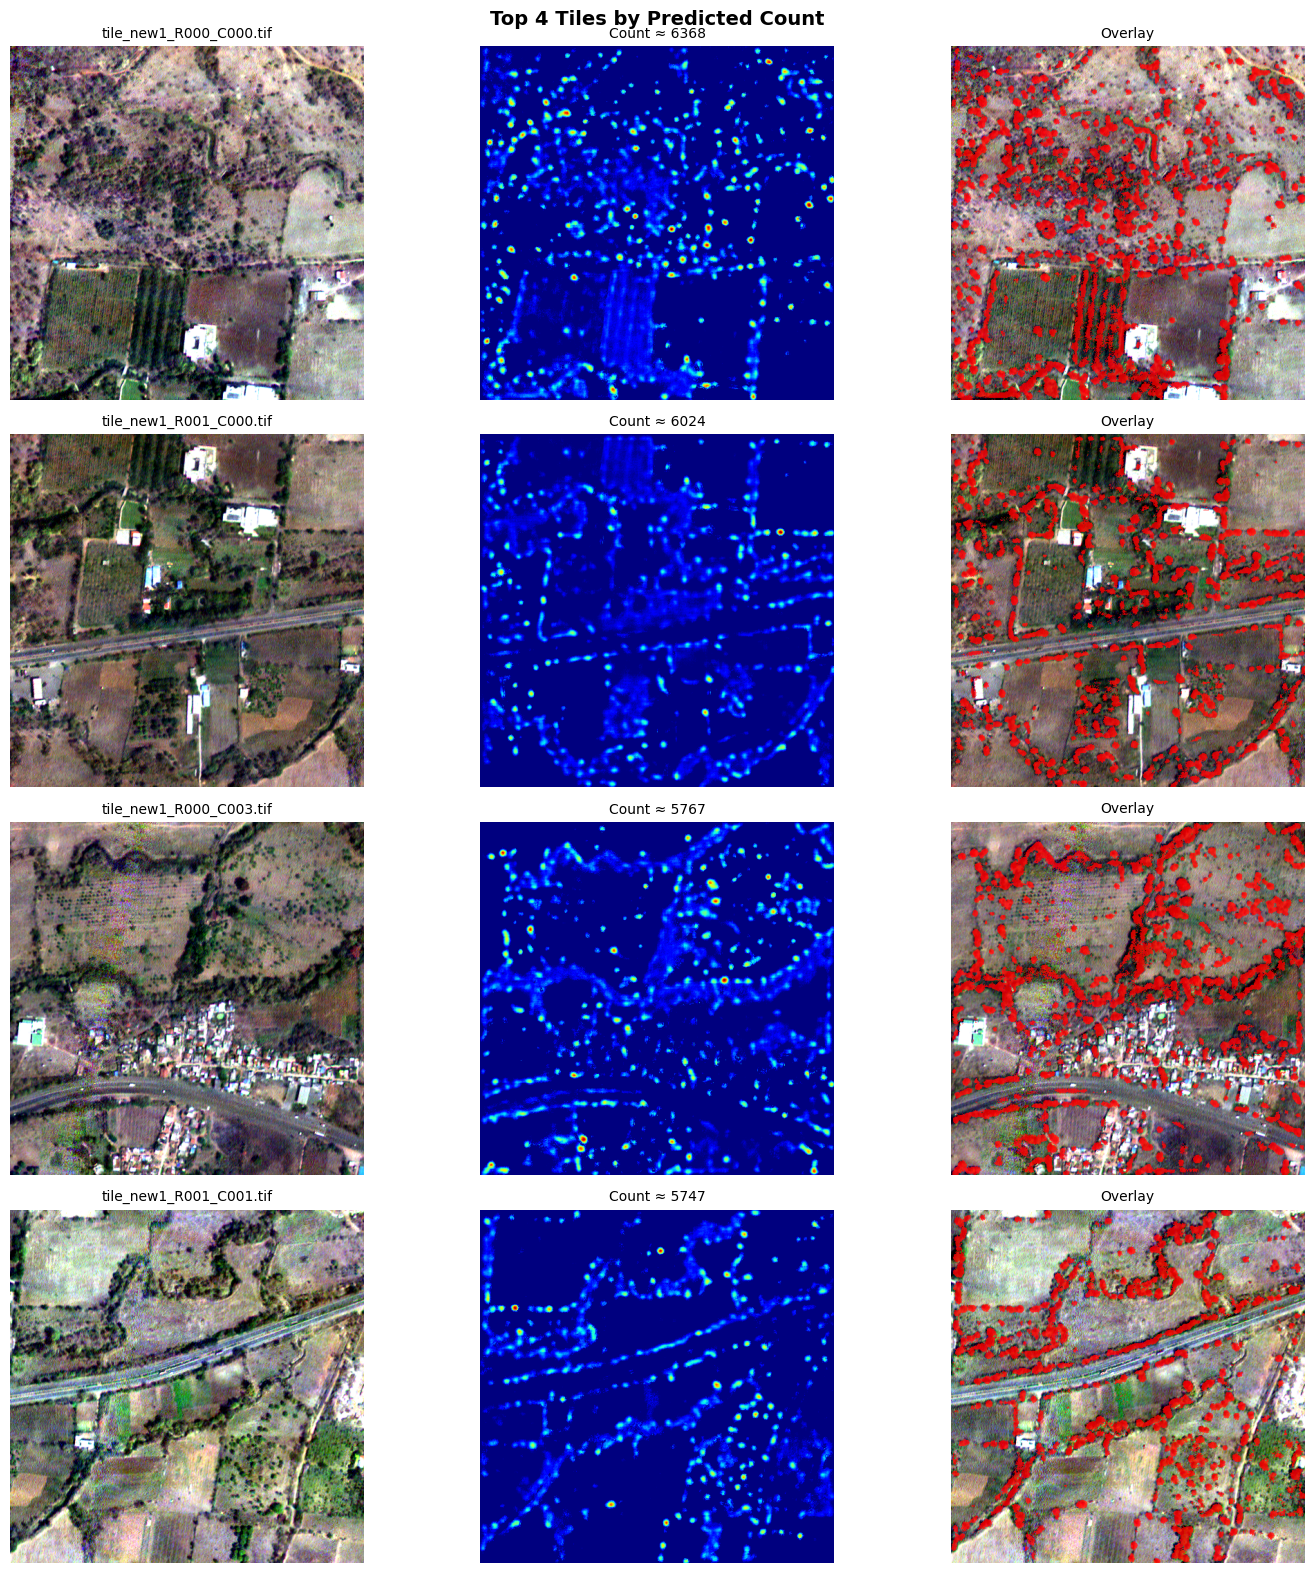

In [9]:
TOP_N = 4

sorted_tiles = sorted(tile_counts, key=lambda x: x[1], reverse=True)[:TOP_N]

fig, axes = plt.subplots(TOP_N, 3, figsize=(15, 4 * TOP_N))
if TOP_N == 1:
    axes = [axes]

for i, (name, count) in enumerate(sorted_tiles):
    path = os.path.join(TILE_DIR, name)
    tile = read_tif(path)
    tile = crop_to_multiple(tile, 4)
    tile_rgb = tensor_to_rgb(tile)

    inp = torch.tensor(tile, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        density = model(inp)[0, 0].cpu().numpy()

    tile_overlay = make_overlay(tile_rgb, density)

    axes[i][0].imshow(tile_rgb)
    axes[i][0].set_title(f'{name}', fontsize=10)
    axes[i][0].axis('off')

    im = axes[i][1].imshow(density, cmap='jet')
    axes[i][1].set_title(f'Count ≈ {count:.0f}', fontsize=10)
    axes[i][1].axis('off')

    axes[i][2].imshow(tile_overlay)
    axes[i][2].set_title('Overlay', fontsize=10)
    axes[i][2].axis('off')

plt.suptitle(f'Top {TOP_N} Tiles by Predicted Count', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()